# 3. GloVe: Global Vectors for Word Representation

I recommend you take a look at these material first.

* http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture3.pdf
* https://nlp.stanford.edu/pubs/glove.pdf

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter
flatten = lambda l: [item for sublist in l for item in sublist]
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

In [2]:
print(torch.__version__)
print(nltk.__version__)

0.2.0+751198f
3.2.4


In [3]:
USE_CUDA = torch.cuda.is_available()

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [4]:
def getBatch(batch_size,train_data):
    random.shuffle(train_data)
    sindex=0
    eindex=batch_size
    while eindex < len(train_data):
        batch = train_data[sindex:eindex]
        temp = eindex
        eindex = eindex+batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [5]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if w in word2index.keys() else word2index["<UNK>"], seq))
    return Variable(LongTensor(idxs))

def prepare_word(word,word2index):
    return Variable(LongTensor([word2index[word]]) if word in word2index.keys() else LongTensor([word2index["<UNK>"]]))

## Data load and Preprocessing 

In [6]:
corpus = list(nltk.corpus.gutenberg.sents('melville-moby_dick.txt'))[:500]
corpus = [[word.lower() for word in sent] for sent in corpus]

### Build vocab

In [7]:
vocab = list(set(flatten(corpus)))

In [8]:
word2index={}
for vo in vocab:
    if vo not in word2index.keys():
        word2index[vo]=len(word2index)
        
index2word={v:k for k,v in word2index.items()}

In [9]:
WINDOW_SIZE = 5
windows =  flatten([list(nltk.ngrams(['<DUMMY>']*WINDOW_SIZE+c+['<DUMMY>']*WINDOW_SIZE,WINDOW_SIZE*2+1)) for c in corpus])

window_data = []

for window in windows:
    for i in range(WINDOW_SIZE*2+1):
        if i==WINDOW_SIZE or window[i]=='<DUMMY>': continue
        window_data.append((window[WINDOW_SIZE],window[i]))


### Weighting Function 

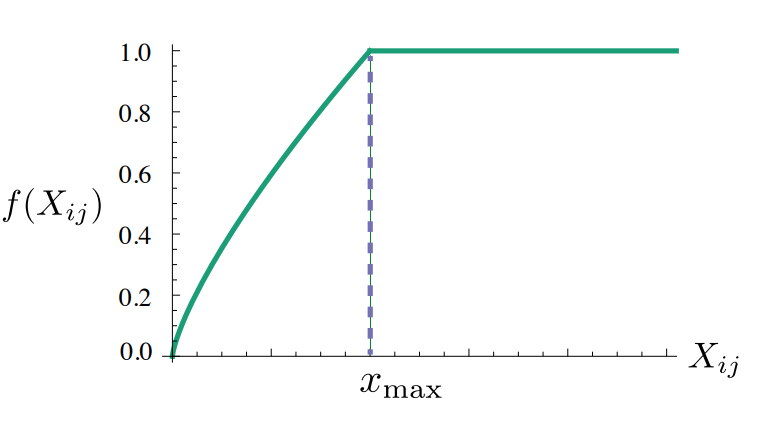

In [4]:
Image('../images/03.glove-weighting-function.png') # borrowed image from https://nlp.stanford.edu/pubs/glove.pdf

In [10]:
def weighting(w_i,w_j):
    try:
        x_ij = X_ik[(w_i,w_j)]
    except:
        x_ij = 1
        
    x_max = 100 #100 # fixed in paper
    alpha = 0.75
    
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha
    else:
        result = 1
    
    return result

### Build Co-occurence Matrix X

Because of model complexity, It is important to determine whether a tighter bound can be placed on the number of nonzero elements of X.

In [11]:
X_i = Counter(flatten(corpus)) # X_i

In [12]:
X_ik_window_5 = Counter(window_data) # Co-occurece in window size 5

In [13]:
X_ik={}
weighting_dic={}

In [14]:
from itertools import combinations_with_replacement

In [15]:
for bigram in combinations_with_replacement(vocab, 2):
    if bigram in X_ik_window_5.keys(): # nonzero elements
        co_occer = X_ik_window_5[bigram]
        X_ik[bigram]=co_occer+1 # log(Xik) -> log(Xik+1) to prevent divergence
        X_ik[(bigram[1],bigram[0])]=co_occer+1
    else:
        pass
        
    weighting_dic[bigram] = weighting(bigram[0],bigram[1])
    weighting_dic[(bigram[1],bigram[0])] = weighting(bigram[1],bigram[0])

In [16]:
test = random.choice(window_data)
print(test)
try:
    print(X_ik[(test[0],test[1])]==X_ik[(test[1],test[0])])
except:
    1

(',', 'was')
True


### Prepare train data

In [17]:
u_p=[] # center vec
v_p=[] # context vec
co_p=[] # log(x_ij)
weight_p=[] # f(x_ij)

for pair in window_data: 
    u_p.append(prepare_word(pair[0],word2index).view(1,-1))
    v_p.append(prepare_word(pair[1],word2index).view(1,-1))
    
    try:
        cooc = X_ik[pair]
    except:
        cooc = 1

    co_p.append(torch.log(Variable(FloatTensor([cooc]))).view(1,-1))
    weight_p.append(Variable(FloatTensor([weighting_dic[pair]])).view(1,-1))
                                  
train_data = list(zip(u_p,v_p,co_p,weight_p))
del u_p
del v_p
del co_p
del weight_p
print(train_data[0]) # tuple (center vec i, context vec j log(x_ij), weight f(w_ij))

(Variable containing:
 703
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, Variable containing:
 23
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, Variable containing:
 0.6931
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]
, Variable containing:
1.00000e-02 *
  5.3183
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]
)


## Modeling 

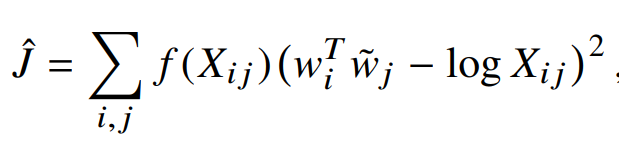

In [5]:
Image('../images/03.glove-objective.png') # borrowed image from https://nlp.stanford.edu/pubs/glove.pdf

In [19]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,projection_dim):
        super(GloVe,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, projection_dim) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, projection_dim) # out embedding
        
        self.v_bias = nn.Embedding(vocab_size,1)
        self.u_bias = nn.Embedding(vocab_size,1)
        
        initrange = (2.0 / (vocab_size+projection_dim))**0.5 # Xavier init
        self.embedding_v.weight.data.uniform_(-initrange, initrange) # init
        self.embedding_u.weight.data.uniform_(-initrange, initrange) # init
        self.v_bias.weight.data.uniform_(-initrange, initrange) # init
        self.u_bias.weight.data.uniform_(-initrange, initrange) # init
        
    def forward(self, center_words,target_words,coocs,weights):
        center_embeds = self.embedding_v(center_words) # B x 1 x D
        target_embeds = self.embedding_u(target_words) # B x 1 x D
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1,2)).squeeze(2) # Bx1
        
        loss = weights*torch.pow(inner_product +center_bias + target_bias - coocs,2)
        
        return torch.sum(loss)
    
    def prediction(self, inputs):
        v_embeds = self.embedding_v(inputs) # B x 1 x D
        u_embeds = self.embedding_u(inputs) # B x 1 x D
                
        return v_embeds+u_embeds # final embed

## Train 

In [22]:
EMBEDDING_SIZE = 50
BATCH_SIZE = 256
EPOCH = 50

In [23]:
losses = []
model = GloVe(len(word2index),EMBEDDING_SIZE)
if USE_CUDA:
    model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
for epoch in range(EPOCH):
    for i,batch in enumerate(getBatch(BATCH_SIZE,train_data)):
        
        inputs, targets, coocs, weights = zip(*batch)
        
        inputs = torch.cat(inputs) # B x 1
        targets = torch.cat(targets) # B x 1
        coocs = torch.cat(coocs)
        weights = torch.cat(weights)
        model.zero_grad()

        loss = model(inputs,targets,coocs,weights)
        
        loss.backward()
        optimizer.step()
    
        losses.append(loss.data.tolist()[0])
    if epoch % 10==0:
        print("Epoch : %d, mean_loss : %.02f" % (epoch,np.mean(losses)))
        losses=[]

Epoch : 0, mean_loss : 236.10
Epoch : 10, mean_loss : 2.27
Epoch : 20, mean_loss : 0.53
Epoch : 30, mean_loss : 0.12
Epoch : 40, mean_loss : 0.04


## Test 

In [25]:
def word_similarity(target,vocab):
    if USE_CUDA:
        target_V = model.prediction(prepare_word(target,word2index))
    else:
        target_V = model.prediction(prepare_word(target,word2index))
    similarities=[]
    for i in range(len(vocab)):
        if vocab[i] == target: continue
        
        if USE_CUDA:
            vector = model.prediction(prepare_word(list(vocab)[i],word2index))
        else:
            vector = model.prediction(prepare_word(list(vocab)[i],word2index))
        
        cosine_sim = F.cosine_similarity(target_V,vector).data.tolist()[0] 
        similarities.append([vocab[i],cosine_sim])
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:10]

In [86]:
test = random.choice(list(vocab))
test

'spiral'

In [87]:
word_similarity(test,vocab)

[['horns', 0.9727935194969177],
 ['swords', 0.9076412916183472],
 ['hooked', 0.8984033465385437],
 ['thar', 0.8066437244415283],
 ['montaigne', 0.8062068819999695],
 ['rabelais', 0.789764940738678],
 ['orion', 0.7886737585067749],
 ['isaiah', 0.780662477016449],
 ['hamlet', 0.7799868583679199],
 ['colnett', 0.7792885899543762]]